In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix


In [2]:

# Step 1: Dataset Preparation
IMG_SIZE = 224
BATCH_SIZE = 32
DATASET_PATH = "dataset"  

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

train_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 1561 images belonging to 15 classes.
Found 383 images belonging to 15 classes.


In [4]:
# Step 2: Build the Model with Transfer Learning
base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                         include_top=False,
                         weights='imagenet')

base_model.trainable = False  # Freeze the base model

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [5]:
# Step 3: Train the Model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

C:\Users\atish\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.4896 - loss: 1.8557 - val_accuracy: 0.8016 - val_loss: 0.6065
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.8839 - loss: 0.4131 - val_accuracy: 0.8381 - val_loss: 0.5421
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.9263 - loss: 0.2628 - val_accuracy: 0.8460 - val_loss: 0.4713
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.9525 - loss: 0.1943 - val_accuracy: 0.8668 - val_loss: 0.4331
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.9613 - loss: 0.1612 - val_accuracy: 0.8721 - val_loss: 0.4517
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.9667 - loss: 0.1203 - val_accuracy: 0.8721 - val_loss: 0.4114
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 128s 3s/step - accuracy: 0.9714 - loss: 0.1037 - val_accuracy: 0.8825 - val_loss: 0.4149
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.9777 - loss: 0.0815 - val_accuracy: 0.8721 - val_los

In [6]:
# Step 4: Evaluate the Model
val_generator.reset()
preds = model.predict(val_generator)
y_pred = np.argmax(preds, axis=1)
y_true = val_generator.classes

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=list(val_generator.class_indices.keys())))

12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step
Classification Report:
              precision    recall  f1-score   support

        Bear       0.91      0.84      0.88        25
        Bird       0.88      0.81      0.85        27
         Cat       0.69      1.00      0.81        24
         Cow       0.88      0.81      0.84        26
        Deer       0.81      0.88      0.85        25
         Dog       0.86      0.75      0.80        24
     Dolphin       0.86      0.96      0.91        25
    Elephant       1.00      0.81      0.89        26
     Giraffe       1.00      1.00      1.00        25
       Horse       0.88      0.88      0.88        26
    Kangaroo       0.77      0.80      0.78        25
        Lion       0.88      0.81      0.84        26
       Panda       0.87      0.96      0.91        27
       Tiger       0.95      0.84      0.89        25
       Zebra       1.00      0.96      0.98        27

    accuracy                           0.87       383
   macro avg      

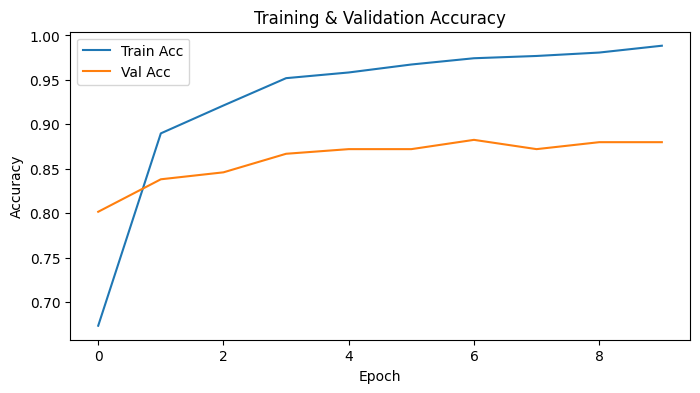

In [7]:
# Step 5: Plotting
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.title("Training & Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()